<a href="https://colab.research.google.com/github/magno12345/UPSO/blob/main/Lab_clf_segun_zonas_peligrosidad_MAGNO_SOTELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo : DBSCAN

In [46]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/DATASETS BIG DATA/Crimenes.csv")

Primero verifico si hay relacion entre las variables con la matriz de correlacion.

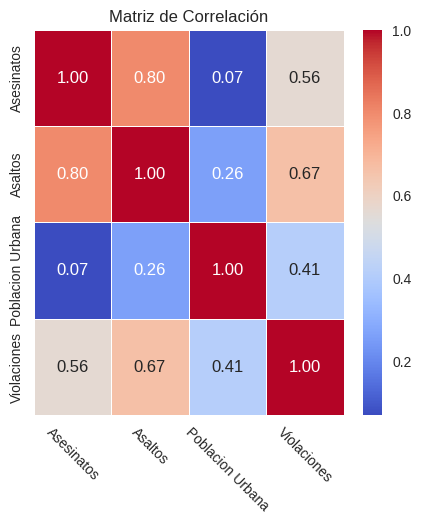

In [47]:
# Calcular matriz de correlación
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(5, 5))
# Crear mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Mostrar el mapa de calor
plt.title('Matriz de Correlación')
plt.xticks(rotation=-45)
plt.show()

La relacion mas fuerte que hubo fue Asaltos-Asesinatos

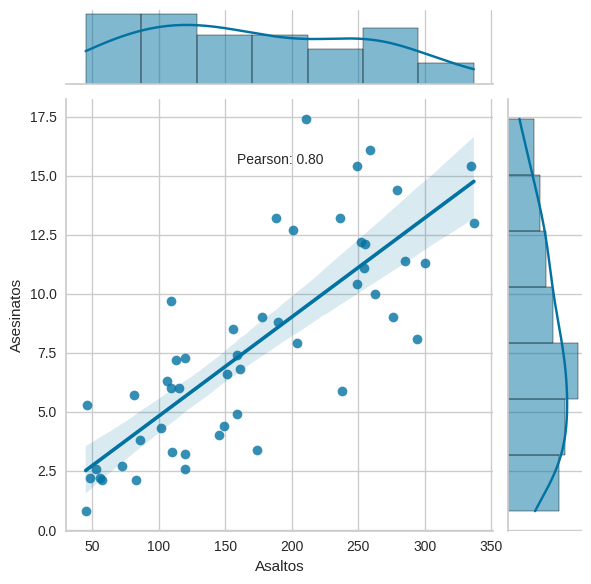

In [48]:
from scipy.stats import pearsonr
# calculating Pearson's correlation
corr, _ = pearsonr(df['Asaltos'], df['Asesinatos'])
# Create a joint plot
jp = sns.jointplot(x='Asaltos', y='Asesinatos', data=df, kind='reg')
# Add correlation text to the plot
jp.ax_joint.annotate(f'Pearson: {corr:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', ha='center', fontsize=10)
# Show the plot
plt.show()

Es difícil decir arbitrariamente qué valores funcionarán mejor. Por lo tanto, primero crearé una matriz de combinaciones debido a que DBSCAN crea clústeres en función de esos dos parámetros,entonces se verificara la cantidad de clústeres generados.

En el codigo debajo use los atributos Asesinatos y Asaltos por la relacion.Ademas porque al usar todos los atributos ,me toma que cerca de la mitad de los estados son outliers ,cuanto no lo tendria que ser


In [49]:
import numpy as np
#No hace falta escalar los datos ,estan en rango aceptable
# Seleccionar características relevantes para clustering
x = df[['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']]
X = df[['Asesinatos', 'Asaltos']]

from itertools import product

eps_values = np.arange(8,12.75,0.25) # valores de epsilon a investigar
min_samples = np.arange(2,10) # valores de min_samples a investigar
DBSCAN_params = list(product(eps_values, min_samples))

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np


no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)

    # Verificar si hay más de un cluster
    unique_labels = np.unique(DBS_clustering.labels_)
    if len(unique_labels) > 1:
        no_of_clusters.append(len(unique_labels))
        sil_score.append(silhouette_score(X, DBS_clustering.labels_))
    else:
        no_of_clusters.append(1)  # Agrega 1 si solo hay un cluster
        sil_score.append(np.nan)  # Opcional: Agrega NaN si no hay suficientes clusters para el coeficiente de silueta

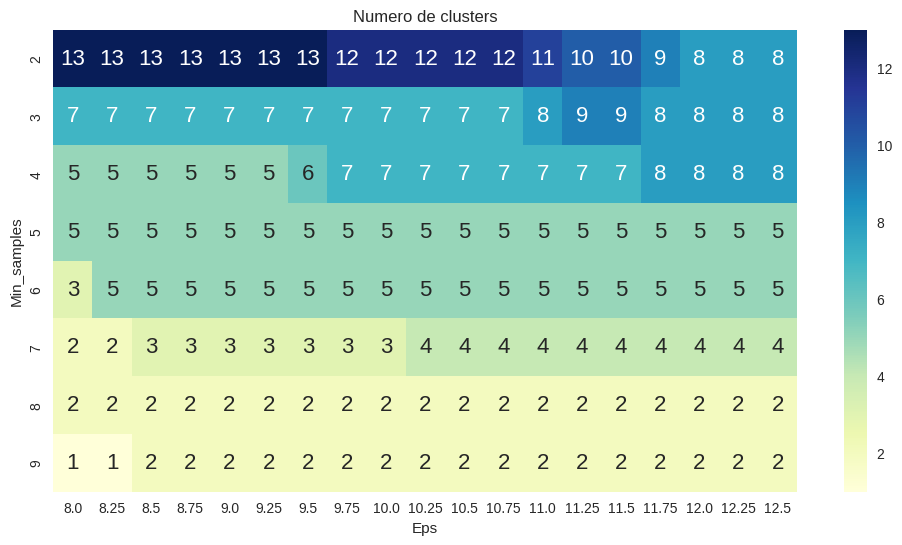

In [51]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Numero de clusters')
plt.show()

El diagrama de calor anterior muestra que el número de grupos varía de 13 a 8. Para decidir qué combinación elegir, usaré una métrica: una puntuación de silueta y la trazaré nuevamente como un mapa de calor.

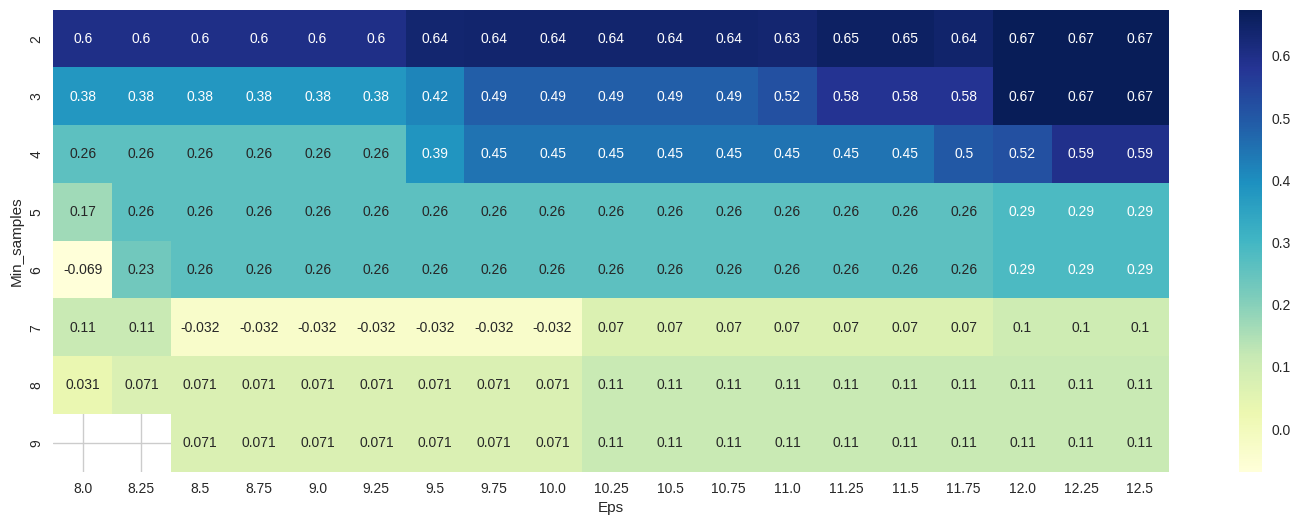

In [52]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

El grafico de arriba muestra que podria usar 2 o 3 muestras ,con valores de epsilon entre 12 a 12.5.

In [53]:
#Uso los valores hallados anteriormente
DBS_clustering = DBSCAN(eps=12.25, min_samples=2).fit(X)

DBSCAN_clustered = X.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
0,9
1,5
2,7
3,10
4,2
5,6
6,4
7,7


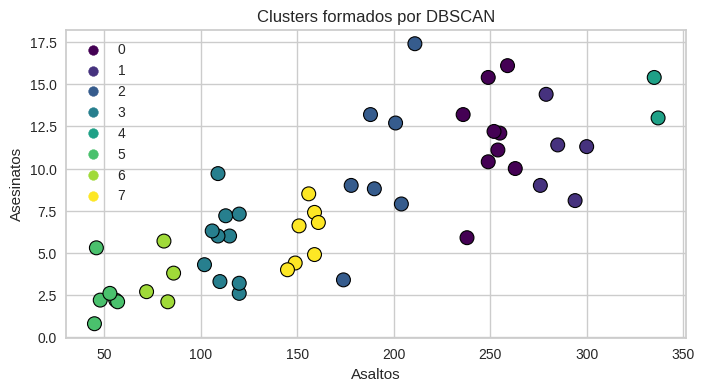

In [54]:
# Visualización de los clusters en un gráfico de dispersión
plt.figure(figsize=(8, 4))

# Scatterplot para puntos que no son ruido
sns.scatterplot(x='Asaltos', y='Asesinatos', hue='Cluster', data=DBSCAN_clustered[DBSCAN_clustered['Cluster'] != -1], palette='viridis', legend='full', s=100,edgecolor='black')

# Scatterplot para outliers (cluster -1)
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster'] == -1]
sns.scatterplot(x='Asaltos', y='Asesinatos', data=outliers, color='red', label='Outliers', s=100, marker='X')

plt.title('Clusters formados por DBSCAN')
plt.legend()
plt.show()

#Modelo : K-means

Hallo el valor k optimo para el modelo , con el metodo del codo.

Use el método de la silueta para determinar el número óptimo de clusters porque mide cuán bien definidos y separados están los clusters.

Me da un k de 2.

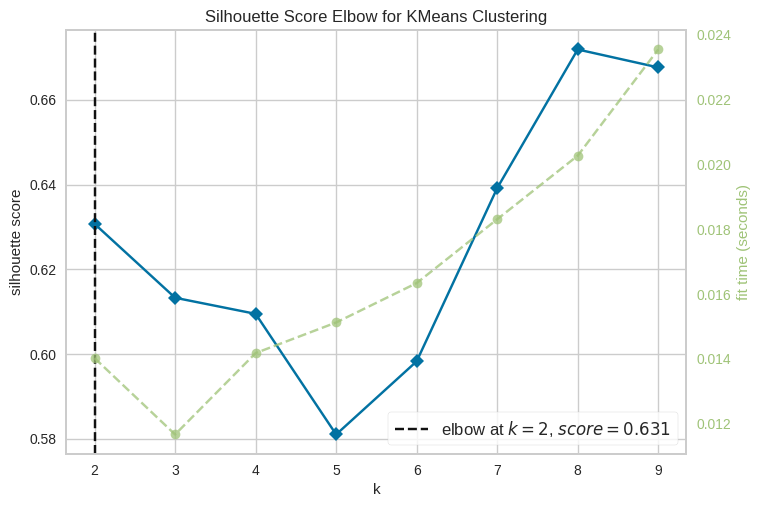

In [55]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init=10,random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette')

visualizer.fit(X)#Se ajusta a los datos asaltos y asesinatos.
visualizer.show()
plt.show()

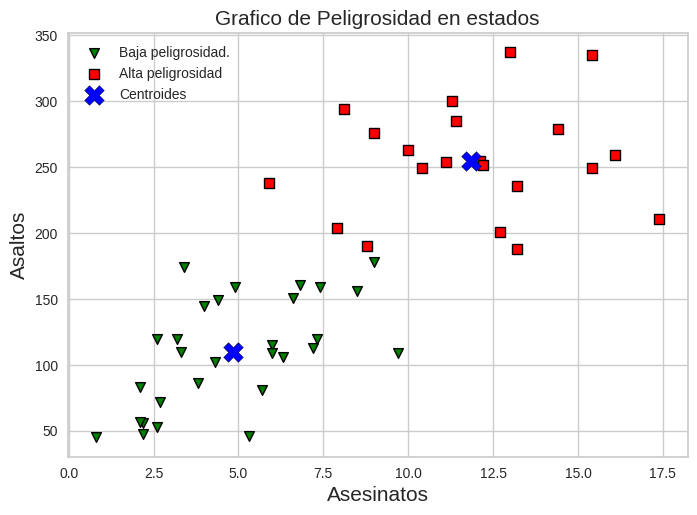

In [56]:
X_copia = X.copy()
#Creo el modelo
modelo = KMeans(n_clusters=2, init='k-means++',n_init=10).fit(X)
#CLUSTERIZO LOS DATOS
modelo_cl = modelo.fit_predict(X)
#CREO UNA COLUMNA CON LOS DATOS CLUSTERIZADOS
X_copia["cluster"] = modelo_cl

#CREO PEQUEÑOS DATAFRAMES QUE CONTIENEN LOS DATOS CON SUS CLUSTERES.
g1_= X_copia[X_copia.cluster==0]#cluster 0 es baja peligrosidad
g2_= X_copia[X_copia.cluster==1]#cluster 1 es alta peligrosidad

#GRAFICO TODOS LOS GRUPOS
plt.scatter(x = g1_["Asesinatos"],y = g1_["Asaltos"],marker="v",color ="green",label="Baja peligrosidad.",edgecolor='black',linewidth=1)
plt.scatter(x = g2_["Asesinatos"],y = g2_["Asaltos"],marker="s",color ="red",label="Alta peligrosidad",edgecolor='black',linewidth=1)
#GRAFICO LOS CENTROIDES.
plt.scatter(modelo.cluster_centers_[:,0], modelo.cluster_centers_[:,1], s=200, marker='X', c='blue', edgecolor='black', label='Centroides')
plt.title("Grafico de Peligrosidad en estados",fontsize=15)
plt.ylabel("Asaltos",fontsize=15)
plt.xlabel("Asesinatos",fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

Muestro como quedaron separados los estados.

In [66]:
#Le agrego la columna estado a x_copia para poder ver cuales son los estados de baja o alta peligrosidad.
X_copia["Estado"] = df["Estado"]


df_cluster_0 = X_copia[X_copia['cluster'] == 0]#baja peligrosidad
# Cambio el nombre de la columna 'cluster' a 'peligrosidad'
df_cluster_0 = df_cluster_0.rename(columns={'cluster': 'Peligrosidad'})
# Cambio el valor 0 a 'baja' en la columna 'peligrosidad'
df_cluster_0['Peligrosidad'] = 'Baja'


df_cluster_1 = X_copia[X_copia['cluster'] == 1]#alta peligrosidad
# Cambio el nombre de la columna 'cluster' a 'peligrosidad'
df_cluster_1 = df_cluster_1.rename(columns={'cluster': 'Peligrosidad'})
# Cambio el valor 0 a 'alta' en la columna 'peligrosidad'
df_cluster_1['Peligrosidad'] = 'Alta'

#concateno los 2 df y los ordeno x indice
resultado = pd.concat([df_cluster_0, df_cluster_1]).sort_index()
resultado

,Asesinatos,Asaltos,Peligrosidad,Estado
0,13.2,236,Alta,Alabama
1,10.0,263,Alta,Alaska
2,8.1,294,Alta,Arizona
3,8.8,190,Alta,Arkansas
4,9.0,276,Alta,California
5,7.9,204,Alta,Colorado
6,3.3,110,Baja,Connecticut
7,5.9,238,Alta,Delaware
8,15.4,335,Alta,Florida
9,17.4,211,Alta,Georgia
